In [1]:
# ! export LD_LIBRARY_PATH=/Users/yanyul/miniconda3/pkgs/r-base-3.3.2-0/lib/R/modules/:${LD_LIBRARY_PATH}

In [2]:
# %env LD_LIBRARY_PATH=/Users/yanyul/miniconda3/pkgs/r-base-3.3.2-0/lib/R/modules/:${LD_LIBRARY_PATH}

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import torch
import pickle

# load tensorqtl scripts
import sys
sys.path.insert(0, '/Users/yanyul/Documents/repo/github/tensorqtl/tensorqtl')
import mixqtl


In [5]:
import rpy2.robjects as robj
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
from rpy2.robjects.conversion import localconverter
rbase = importr('base')
rstats = importr('stats')
r_mixqtl = importr('mixqtl')

/Users/yanyul/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/Users/yanyul/miniconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [6]:
from mixqtl import *

# df = map_nominal_with_r_mixqtl(log_counts_df.loc[ix], hap1_df, hap2_df, variant_df, 
#                    libsize_df, phenotype_df.loc[ix], ref_df.loc[ix], alt_df.loc[ix],
#                    phenotype_pos_df.loc[ix], covariates_df, output_prefix,
#                    output_dir=f'{datadir}/', verbose=True)

def map_nominal_with_r_mixqtl(log_counts_imp_df, hap1_df, hap2_df, variant_df, lib_df, counts_df, ref_df, alt_df,
                phenotype_pos_df, covariates_df, prefix, 
                window=1000000, output_dir='.', write_stats=True, logger=None, verbose=True):
    """
    cis-QTL mapping: mixQTL model, nominal associations for all variant-phenotype pairs

    Association results for each chromosome are written to parquet files
    in the format <output_dir>/<prefix>.cis_qtl_pairs.mixQTL.<chr>.parquet
    """
    assert np.all(counts_df.columns==covariates_df.index)
    assert np.all(counts_df.columns==lib_df.index)
    assert np.all(counts_df.columns==log_counts_imp_df.columns)
    assert np.all(counts_df.index==log_counts_imp_df.index)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if logger is None:
        logger = SimpleLogger()

    logger.write('cis-QTL mapping: nominal associations for all variant-phenotype pairs')
    logger.write('  * {} samples'.format(counts_df.shape[1]))
    logger.write('  * {} phenotypes'.format(counts_df.shape[0]))
    logger.write('  * {} covariates'.format(covariates_df.shape[1]))
    logger.write('  * {} variants'.format(variant_df.shape[0]))

    genotype_ix = np.array([hap1_df.columns.tolist().index(i) for i in counts_df.columns])
    genotype_ix_t = torch.from_numpy(genotype_ix).to(device)

    # DO add intercept to covariates
    covariates0_t = torch.tensor(np.c_[np.ones(covariates_df.shape[0]), covariates_df],
                                 dtype=torch.float32).to(device)
    # DO NOT add intercept to covariates
    covariates0_r = cov2r(covariates_df)
    lib_r = np2rvec(np.array(libsize_df['lib_size'].tolist()))

    # dof = phenotype_df.shape[1] - 2 - covariates_df.shape[1]

    igm = InputGeneratorMix(hap1_df, hap2_df, variant_df, counts_df, log_counts_imp_df, 
                            ref_df, alt_df, phenotype_pos_df, window=window)
    # iterate over chromosomes
    start_time = time.time()
    k = 0
    logger.write('  * Computing associations')
    for chrom in igm.chrs:
        logger.write('    Mapping chromosome {}'.format(chrom))
        # allocate arrays
        n = 0
        for i in igm.phenotype_pos_df[igm.phenotype_pos_df['chr']==chrom].index:
            j = igm.cis_ranges[i]
            n += j[1] - j[0] + 1

        chr_res = OrderedDict()
        chr_res['method'] = []
        chr_res['phenotype_id'] = []
        chr_res['variant_id'] = []
        chr_res['tss_distance'] =   np.empty(n, dtype=np.int32)
        chr_res['maf_trc'] =        np.empty(n, dtype=np.float32)
        chr_res['ma_samples_trc'] = np.empty(n, dtype=np.int32)
        chr_res['ma_count_trc'] =   np.empty(n, dtype=np.int32)
        chr_res['beta_trc'] =       np.empty(n, dtype=np.float32)
        chr_res['beta_se_trc'] =    np.empty(n, dtype=np.float32)
        chr_res['tstat_trc'] =      np.empty(n, dtype=np.float32)
        chr_res['pval_trc'] =       np.empty(n, dtype=np.float64)
        chr_res['samples_trc'] =    np.empty(n, dtype=np.int32)
        chr_res['dof_trc'] =        np.empty(n, dtype=np.int32)
        chr_res['beta_asc'] =       np.empty(n, dtype=np.float32)
        chr_res['beta_se_asc'] =    np.empty(n, dtype=np.float32)
        chr_res['tstat_asc'] =      np.empty(n, dtype=np.float32)
        chr_res['pval_asc'] =       np.empty(n, dtype=np.float64)
        chr_res['samples_asc'] =    np.empty(n, dtype=np.int32)
        chr_res['dof_asc'] =        np.empty(n, dtype=np.int32)
        chr_res['beta_meta'] =      np.empty(n, dtype=np.float32)
        chr_res['beta_se_meta'] =   np.empty(n, dtype=np.float32)
        chr_res['tstat_meta'] =     np.empty(n, dtype=np.float32)
        chr_res['pval_meta'] =      np.empty(n, dtype=np.float64)

        start = 0
        counter = 0
        for k, (raw_counts, counts, ref, alt, hap1, hap2, genotype_range, phenotype_id) in enumerate(igm.generate_data(chrom=chrom, verbose=verbose), k+1):
            
            # final test
            # only on one gene
            if phenotype_id != 'ENSG00000198951.6':
                continue
                
            
            
            # copy data to GPU
            hap1_t = hap1  # torch.tensor(hap1, dtype=torch.float).to(device)
            hap1_tt = astensor(hap1, device)
            hap2_t = hap2  # torch.tensor(hap2, dtype=torch.float).to(device)
            hap2_tt = astensor(hap2, device)
            # subset samples
            hap1_t = hap1_t[:,genotype_ix_t]
            hap2_t = hap2_t[:,genotype_ix_t]
            hap1_tt = hap1_tt[:,genotype_ix_t]
            hap2_tt = hap2_tt[:,genotype_ix_t]
            
            ref_t = ref  # torch.tensor(ref, dtype=torch.float).to(device)
            alt_t = alt  # torch.tensor(alt, dtype=torch.float).to(device)
            raw_counts_t = raw_counts  # torch.tensor(raw_counts, dtype=torch.float).to(device)
            counts_t = counts  # torch.tensor(counts, dtype=torch.float).to(device)
            ref_tt = astensor(ref, device)
            alt_tt = astensor(alt, device)
            raw_counts_tt = astensor(raw_counts, device)
            counts_tt = astensor(counts, device)
            

            genotypes_t = hap1_t + hap2_t
            genotypes_t = genotypes_t.astype(float)
            hap1_t = hap1_t.astype(float)
            hap2_t = hap2_t.astype(float)
            genotypes_t[genotypes_t==-2] = -1
            genotypes_tt = hap1_tt + hap2_tt
            genotypes_tt[genotypes_tt==-2] = -1
            impute_mean_np(genotypes_t)
            impute_mean_np(hap1_t)
            impute_mean_np(hap2_t)
            tensorqtl.impute_mean(genotypes_tt)
            tensorqtl.impute_mean(hap1_tt)
            tensorqtl.impute_mean(hap2_tt)

            variant_ids = variant_df.index[genotype_range[0]:genotype_range[-1]+1]
            tss_distance = np.int32(variant_df['pos'].values[genotype_range[0]:genotype_range[-1]+1] - igm.phenotype_tss[phenotype_id])
            
            
#             print(raw_counts_tt[:10])
#             print(counts_tt[:10])
            
#             res_trc, samples_trc, dof_trc = trc_calc(genotypes_t, log_counts_t, raw_counts_t,
#                                                      covariates0_t, count_threshold=100, select_covariates=True)
#             # res = [tstat, beta, beta_se, maf, ma_samples, ma_count]
#             # break

#             res_asc, samples_asc, dof_asc = asc_calc(hap1_t, hap2_t, ref_t, alt_t)
#             # res = [tstat_t, beta_t, beta_se_t]
#             rbase.saveRDS(np2rvec(counts_t.numpy()), 'c.rds')
#             rbase.saveRDS(lib_r, 'l.rds')
#             rbase.saveRDS(covariates0_r, 'co.rds')
            indiv_offset = r_mixqtl.regress_against_covariate(
                np2rvec(counts_t), 
                lib_r, 
                covariates0_r
            )
#             rbase.saveRDS(np2rmat(hap1_t), 'h1.rds')
#             rbase.saveRDS(np2rmat(hap2_t), 'h2.rds')
#             rbase.saveRDS(np2rvec(ref_t), 'a1.rds')
#             rbase.saveRDS(np2rvec(alt_t), 'a2.rds')
#             rbase.saveRDS(np2rvec(counts_t), 'cc.rds')
#             rbase.saveRDS(lib_r, 'rr.rds')
#             rbase.saveRDS(covariates0_r, 'co.rds')
#             print(hap1_t.shape)
#             print(ref_t.shape)
#             print(alt_t.shape)
#             print(counts_t.shape)
            out = r_mixqtl.mixqtl(
                np2rmat(hap1_t.T), 
                np2rmat(hap2_t.T), 
                np2rvec(ref_t), 
                np2rvec(alt_t), 
                np2rvec(counts_t), 
                lib_r, 
                cov_offset = indiv_offset, 
                trc_cutoff = 100, 
                asc_cutoff = 50, 
                weight_cap = 100, 
                asc_cap = 1000
            )
#             rbase.saveRDS(out, 'out.rds')

            out_df = out2pd(out)
            
            
#             print(raw_counts_tt[:10])
#             print(counts_tt[:10])
#             pickle.dump( genotypes_tt, open( "geno.p", "wb" ) )
#             pickle.dump( raw_counts_tt, open( "raw_c.p", "wb" ) )
#             pickle.dump( counts_tt, open( "cc.p", "wb" ) )
#             pickle.dump( covariates0_t, open( "co.p", "wb" ) )
            res_asc, samples_asc, dof_asc = mixqtl.asc_calc(hap1_tt, hap2_tt, ref_tt, alt_tt)
            res_trc, samples_trc, dof_trc = mixqtl.trc_calc(genotypes_tt, raw_counts_tt, counts_tt,
                                                     covariates0_t, count_threshold=100, select_covariates=True)
#             print(raw_counts_tt[:10])
#             print(counts_tt[:10])
#             print(raw_counts_tt)
#             print(counts_tt)
#             print(out_df.iloc[:, 5:])
#             print(res_asc) # res_asc[0][:10], res_asc[1][:10], res_asc[3][:10])
        
#             pickle.dump( hap1_tt, open( "h1.p", "wb" ) )
#             pickle.dump( hap2_tt, open( "h2.p", "wb" ) )
#             pickle.dump( ref_tt, open( "a1.p", "wb" ) )
#             pickle.dump( alt_tt, open( "a2.p", "wb" ) )
            
#             
#             print(out_df[:10])
#             print(res_trc[0][:10], res_trc[1][:10], res_trc[3][:10])
#             break
        
            n = len(variant_ids)
#             [tstat_trc, beta_trc, beta_se_trc, maf_trc, ma_samples_trc, ma_count_trc] = res_trc

            chr_res['method'].extend(['r_mixqtl']*n)
            chr_res['phenotype_id'].extend([phenotype_id]*n)
            chr_res['variant_id'].extend(variant_ids)
            chr_res['tss_distance'][start:start+n] = tss_distance
#             chr_res['maf_trc'][start:start+n] = maf_trc.cpu().numpy()
#             chr_res['ma_samples_trc'][start:start+n] = ma_samples_trc.cpu().numpy()
#             chr_res['ma_count_trc'][start:start+n] = ma_count_trc.cpu().numpy()
            chr_res['beta_trc'][start:start+n] = out_df['bhat.trc'].tolist() # beta_trc.cpu().numpy()
            chr_res['beta_se_trc'][start:start+n] = out_df['se.trc'].tolist()
            chr_res['tstat_trc'][start:start+n] = out_df['stat.trc'].tolist()
            chr_res['pval_trc'][start:start+n] = out_df['pval.trc'].tolist()
#             chr_res['samples_trc'][start:start+n] = samples_trc
#             chr_res['dof_trc'][start:start+n] = dof_trc

            if True:
#                 [tstat_asc, beta_asc, beta_se_asc] = res_asc
                chr_res['beta_asc'][start:start+n] = out_df['bhat.asc'].tolist()
                chr_res['beta_se_asc'][start:start+n] = out_df['se.asc'].tolist()
                chr_res['tstat_asc'][start:start+n] = out_df['stat.asc'].tolist()
                chr_res['pval_asc'][start:start+n] = out_df['pval.asc'].tolist()
#                 chr_res['samples_asc'][start:start+n] = samples_asc
#                 chr_res['dof_asc'][start:start+n] = dof_asc
                # meta-analysis
#                 d = 1/beta_se_trc**2 + 1/beta_se_asc**2
#                 beta_meta_t = (beta_asc/beta_se_asc**2 + beta_trc/beta_se_trc**2) / d
#                 beta_se_meta_t = 1 / torch.sqrt(d)
#                 tstat_meta_t = beta_meta_t / beta_se_meta_t
                chr_res['beta_meta'][start:start+n] = out_df['bhat.meta'].tolist()
                chr_res['beta_se_meta'][start:start+n] = out_df['se.meta'].tolist()
                chr_res['tstat_meta'][start:start+n] = out_df['stat.meta'].tolist()
                chr_res['pval_meta'][start:start+n] = out_df['pval.meta'].tolist()

                
                
            
            chr_res['method'].extend(['py_mixqtl']*n)
            [tstat_trc, beta_trc, beta_se_trc, maf_trc, ma_samples_trc, ma_count_trc] = res_trc
            
            start = start + n
            chr_res['phenotype_id'].extend([phenotype_id]*n)
            chr_res['variant_id'].extend(variant_ids)
            chr_res['tss_distance'][start:start+n] = tss_distance
            chr_res['maf_trc'][start:start+n] = maf_trc.cpu().numpy()
            chr_res['ma_samples_trc'][start:start+n] = ma_samples_trc.cpu().numpy()
            chr_res['ma_count_trc'][start:start+n] = ma_count_trc.cpu().numpy()
            chr_res['beta_trc'][start:start+n] = beta_trc.cpu().numpy()
            chr_res['beta_se_trc'][start:start+n] = beta_se_trc.cpu().numpy()
            chr_res['tstat_trc'][start:start+n] = tstat_trc.cpu().numpy()
            chr_res['samples_trc'][start:start+n] = samples_trc
            chr_res['dof_trc'][start:start+n] = dof_trc
            chr_res['pval_trc'][start:start+n] = 2*stats.t.cdf(-np.absolute(chr_res['tstat_trc'][start:start+n]), chr_res['dof_trc'][start:start+n])
            if res_asc is not None:
                [tstat_asc, beta_asc, beta_se_asc] = res_asc
                chr_res['beta_asc'][start:start+n] = beta_asc.cpu().numpy()
                chr_res['beta_se_asc'][start:start+n] = beta_se_asc.cpu().numpy()
                chr_res['tstat_asc'][start:start+n] = tstat_asc.cpu().numpy()
                chr_res['samples_asc'][start:start+n] = samples_asc
                chr_res['dof_asc'][start:start+n] = dof_asc
                chr_res['pval_asc'][start:start+n] = 2*stats.t.cdf(-np.absolute(chr_res['tstat_trc'][start:start+n]), chr_res['dof_asc'][start:start+n])
                # meta-analysis
                d = 1/beta_se_trc**2 + 1/beta_se_asc**2
                beta_meta_t = (beta_asc/beta_se_asc**2 + beta_trc/beta_se_trc**2) / d
                beta_se_meta_t = 1 / torch.sqrt(d)
                tstat_meta_t = beta_meta_t / beta_se_meta_t
                chr_res['beta_meta'][start:start+n] = beta_meta_t.cpu().numpy()
                chr_res['beta_se_meta'][start:start+n] = beta_se_meta_t.cpu().numpy()
                chr_res['tstat_meta'][start:start+n] = tstat_meta_t.cpu().numpy()
                chr_res['pval_meta'][start:start+n] = 2*stats.norm.cdf(-np.absolute(chr_res['tstat_meta'][start:start+n]))

            
            
            start += n  # update pointer
            counter += 1
#             if counter > 1:  # only compute the first ten genes 
#                 break

        logger.write('    time elapsed: {:.2f} min'.format((time.time()-start_time)/60))

        # convert to dataframe, compute p-values and write current chromosome
        if start < len(chr_res['maf_trc']):
            for x in chr_res:
                chr_res[x] = chr_res[x][:start]
        chr_res_df = pd.DataFrame(chr_res)
#         chr_res_df['pval_trc'] = 2*stats.t.cdf(-chr_res_df['tstat_trc'].abs(), chr_res_df['dof_trc'])
#         chr_res_df['pval_asc'] = 2*stats.t.cdf(-chr_res_df['tstat_trc'].abs(), chr_res_df['dof_asc'])
        chr_res_df['pval_meta'] = 2*stats.norm.cdf(-chr_res_df['tstat_meta'].abs())
        
            # torch.distributions.StudentT.cdf is still not implemented --> use scipy
            # m = chr_res_df['pval_nominal'].notnull()
            # chr_res_df.loc[m, 'pval_nominal'] = 2*stats.t.cdf(-chr_res_df.loc[m, 'pval_nominal'].abs(), dof)
#             chr_res_df['pval_trc'] = 2*stats.t.cdf(-chr_res_df['tstat_trc'].abs(), chr_res_df['dof_trc'])
#             chr_res_df['pval_asc'] = 2*stats.t.cdf(-chr_res_df['tstat_trc'].abs(), chr_res_df['dof_asc'])
#             chr_res_df['pval_meta'] = 2*stats.norm.cdf(-chr_res_df['tstat_meta'].abs())

    logger.write('done.')
    return chr_res_df


# Load data

In [7]:
######################## data pointer ##########################
datadir = '/Users/yanyul/Desktop/tmp/GEUVADIS-mixqtl'

# genotypes
hap1_file = f'{datadir}/tempo-GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.hap1.parquet'
hap2_file = f'{datadir}/tempo-GEUVADIS.chr22.PH1PH2_465.IMPFRQFILT_BIALLELIC_PH.annotv2.genotypes.hap2.parquet'

# total count matrix
trc_file = f'{datadir}/geuvadis.total_count.bed.gz'

# allele-specific count matrix
asc1_file = f'{datadir}/geuvadis.asc.h1.tsv.gz'
asc2_file = f'{datadir}/geuvadis.asc.h2.tsv.gz'

# library size
lib_file = f'{datadir}/geuvadis.library_size.tsv.gz'

# covariate matrix
covar_file = f'{datadir}/geuvadis.covariate.txt.gz'

# output prefix
output_prefix = 'geuvadis.mixqtl_test_r_mixqtl'

# a reference eqtl result
eqtl_reference = '/Users/yanyul/Downloads/EUR373.gene.cis.FDR5.all.rs137.txt.gz'

####################### load data ########################
# load genotypes
hap1_df = pd.read_parquet(hap1_file)
hap2_df = pd.read_parquet(hap2_file)
variant_df = pd.DataFrame({'chrom':hap1_df.index.map(lambda x: 'chr' + x.split('_')[1]),
                           'pos':  hap1_df.index.map(lambda x: int(x.split('_')[2]))}, index=hap1_df.index)
def trc_qc(df, pos_df, threshold = 100, min_obs = 50):
    t__ = df >= threshold
    npass = t__.sum(axis = 1)
    df = df.loc[npass >= min_obs, :]
    pos_df = pos_df.loc[npass >= min_obs, :]
    return df, pos_df
# load total count 
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(trc_file)
phenotype_df, phenotype_pos_df = trc_qc(phenotype_df, phenotype_pos_df)
libsize_df = pd.read_csv(lib_file, header = 0, sep = '\t', compression = 'gzip')
libsize_df = libsize_df.set_index('indiv')
libsize_s = libsize_df.loc[phenotype_df.columns.tolist(), 'lib_size']
libsize_df = libsize_df.loc[phenotype_df.columns.tolist(), :]
# compute log(count / libsize)
log_counts_df = np.log(phenotype_df / libsize_s / 2)
log_counts_df = log_counts_df.loc[phenotype_df.index]
log_counts_df[log_counts_df == -np.Inf] = np.NaN
# libsize_s = libsize_df.loc[phenotype_df.columns.tolist(), 'lib_size']
# load allele-specific count
ref_df = pd.read_csv(asc1_file, header = 0, sep = '\t', compression = 'gzip')
ref_df = ref_df.set_index('gene_list')
alt_df = pd.read_csv(asc2_file, header = 0, sep = '\t', compression = 'gzip')
alt_df = alt_df.set_index('gene_list')
# load covariate
covariates_df = pd.read_csv(covar_file, sep = '\t', index_col = 0, compression = 'gzip').T
covariates_df = covariates_df.loc[phenotype_df.columns.tolist(), :]
# the call
# ix = phenotype_pos_df[phenotype_pos_df['chr']=='chr22'].index
# mixqtl.map_nominal(hap1_df, hap2_df, variant_df, 
#                    log_counts_df.loc[ix], phenotype_df.loc[ix], ref_df.loc[ix], alt_df.loc[ix],
#                    phenotype_pos_df.loc[ix], covariates_df, output_prefix,
#                    output_dir=f'{datadir}/', verbose=True)

/Users/yanyul/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


In [8]:
log_counts_df.loc['ENSG00000198951.6', :]

HG00096   -10.958615
HG00097   -10.826342
HG00099   -10.779747
HG00100   -11.103937
HG00101   -11.029097
             ...    
NA20815   -10.500453
NA20816   -10.807625
NA20819   -11.020760
NA20826   -10.938245
NA20828   -11.052531
Name: ENSG00000198951.6, Length: 462, dtype: float64

In [9]:
covariates_df

ID,Gender,peerFactor1,peerFactor2,peerFactor3,peerFactor4,peerFactor5,peerFactor6,peerFactor7,peerFactor8,peerFactor9,...,peerFactor16,peerFactor17,peerFactor18,peerFactor19,peerFactor20,PC1,PC2,PC3,PC4,PC5
HG00096,1.0,0.046366,-0.004686,-0.048464,0.004120,-0.029341,-0.031301,0.023991,-0.061207,0.020687,...,0.018305,0.040723,0.020110,-0.007606,0.011170,0.022501,0.000535,0.000731,0.005828,0.000928
HG00097,2.0,0.046620,-0.031239,-0.008522,0.051710,-0.036143,0.003493,0.023543,0.004894,0.041864,...,0.050944,0.007593,-0.013338,-0.006689,0.041111,0.022811,0.008555,0.004313,-0.001647,0.002872
HG00099,2.0,0.046444,0.012299,-0.064901,-0.026883,-0.003078,0.007780,-0.021818,-0.041719,0.006679,...,-0.019212,-0.052536,-0.056724,-0.063105,0.046889,0.020500,0.009632,0.005413,-0.000129,-0.000618
HG00100,2.0,0.046719,-0.051308,-0.006101,0.001915,0.028073,0.003471,0.026724,-0.013055,0.003549,...,0.036239,-0.001778,0.009435,-0.077169,-0.047436,0.022926,0.001408,0.001473,-0.003182,0.004024
HG00101,1.0,0.046118,-0.000450,-0.031309,0.012384,-0.018783,0.053841,0.029915,-0.097233,-0.003664,...,0.032754,0.027597,0.001696,-0.036102,-0.039545,0.020227,0.005903,0.003198,-0.001006,-0.005806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA20815,1.0,0.046748,-0.055311,-0.024966,-0.067048,0.011932,0.025748,-0.063080,0.023525,0.017671,...,0.005226,0.043876,-0.012694,0.057283,-0.046584,0.021370,-0.000912,-0.000968,0.001748,-0.001378
NA20816,1.0,0.046706,-0.053118,-0.017221,0.001813,0.040580,0.014194,-0.009265,0.075639,0.000953,...,-0.024295,0.023512,0.028076,0.039034,0.039262,0.021355,-0.000372,-0.004864,-0.006173,0.004705
NA20819,2.0,0.046183,-0.038606,-0.032763,-0.013081,0.012611,-0.023183,0.063119,-0.027642,-0.075595,...,-0.060285,-0.015428,0.015353,-0.024165,0.047781,0.020097,-0.002093,-0.002026,0.000194,0.000887
NA20826,2.0,0.046734,-0.010490,-0.019791,-0.045617,-0.040916,0.005006,-0.019742,-0.042388,-0.004936,...,-0.009194,0.003624,0.036060,0.002780,0.060609,0.021348,-0.002374,-0.001060,0.003721,-0.005614


In [10]:
def np2rmat(nparray):
    nr, nc = nparray.shape
    xvec = robj.FloatVector(nparray.reshape((nparray.size)))
    xr = robj.r.matrix(xvec, nrow = nr, ncol = nc, byrow = True)
    return xr

def np2rvec(npvec):
    xvec = robj.FloatVector(npvec.reshape((npvec.size)))
    return xvec

def cov2r(cov_df):
    with localconverter(robj.default_converter + pandas2ri.converter):
        r_from_pd_df = robj.conversion.py2rpy(cov_df.transpose().reset_index())
    return r_from_pd_df
def out2pd(out_rdf):
    with localconverter(robj.default_converter + pandas2ri.converter):
        pd_from_r_df = robj.conversion.rpy2py(out_rdf)
    return pd_from_r_df
def impute_mean_np(genotypes_t):
    """Impute missing genotypes to mean"""
    m = genotypes_t == -1
    a = genotypes_t.sum(1)
    b = m.sum(1)
    mu = np.true_divide((a + b), (genotypes_t.shape[1] - b))
    ix = m.nonzero()[0]
#     print(ix)
#     print(mu)
    genotypes_t[m] = mu[ix]
def astensor(m, device):
    return torch.tensor(m, dtype=torch.float).to(device)

In [11]:
# phenotype_df

In [12]:
# map only chr1 for tests:
ix = phenotype_pos_df[phenotype_pos_df['chr']=='chr22'].index
df = map_nominal_with_r_mixqtl(log_counts_df.loc[ix], hap1_df, hap2_df, variant_df, 
                   libsize_df, phenotype_df.loc[ix], ref_df.loc[ix], alt_df.loc[ix],
                   phenotype_pos_df.loc[ix], covariates_df, output_prefix,
                   output_dir=f'{datadir}/', verbose=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 462 samples
  * 403 phenotypes
  * 26 covariates
  * 493859 variants
  * checking phenotypes: 403/403
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 403/403


/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/yanyul/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


    time elapsed: 0.17 min
done.


In [13]:
# df_py = pd.read_parquet(f'{datadir}/geuvadis.mixqtl_run_trc.cis_qtl_pairs.mixQTL.chr22.parquet')
# df_r = pd.read_parquet(f'{datadir}/{output_prefix}.cis_qtl_pairs.mixQTL.chr22.parquet')

In [14]:
df_r = df.loc[df['method'] == 'r_mixqtl']
df_py = df.loc[df['method'] == 'py_mixqtl']
df_ = df_r.set_index('variant_id').join(df_py.set_index('variant_id'), lsuffix='_r', rsuffix='_py')

In [15]:
df_[['pval_trc_r', 'pval_trc_py']]

,pval_trc_r,pval_trc_py
variant_id,,
snp_22_41466907,0.936592,0.936647
snp_22_41466965,0.426911,0.427324
snp_22_41467164,0.819936,0.820024
indel:1I_22_41467223,0.754564,0.754717
snp_22_41467352,0.330777,0.331302
...,...,...
snp_22_43466441,0.311080,0.311619
snp_22_43466542,NaN,NaN
snp_22_43466594,0.455890,0.456265


In [16]:
df_[['beta_trc_r', 'beta_se_trc_r', 'beta_trc_py', 'beta_se_trc_py']]

,beta_trc_r,beta_se_trc_r,beta_trc_py,beta_se_trc_py
variant_id,,,,
snp_22_41466907,-0.010096,0.126907,-0.010093,0.126907
snp_22_41466965,0.200793,0.252732,0.200792,0.252732
snp_22_41467164,0.057565,0.252892,0.057569,0.252892
indel:1I_22_41467223,-0.024126,0.077172,-0.024125,0.077172
snp_22_41467352,0.245711,0.252646,0.245704,0.252646
...,...,...,...,...
snp_22_43466441,0.069478,0.068589,0.069477,0.068589
snp_22_43466542,NaN,NaN,NaN,NaN
snp_22_43466594,0.060247,0.080800,0.060248,0.080800


In [17]:
df_[['beta_asc_r', 'beta_se_asc_r', 'beta_asc_py', 'beta_se_asc_py']]

,beta_asc_r,beta_se_asc_r,beta_asc_py,beta_se_asc_py
variant_id,,,,
snp_22_41466907,0.033906,0.046172,0.033906,0.046172
snp_22_41466965,-0.076618,0.075204,-0.076618,0.075204
snp_22_41467164,0.102710,0.074883,0.102710,0.074883
indel:1I_22_41467223,0.010954,0.025461,0.010954,0.025461
snp_22_41467352,0.017591,0.086076,0.017591,0.086076
...,...,...,...,...
snp_22_43466441,0.010716,0.017961,0.010716,0.017961
snp_22_43466542,NaN,NaN,NaN,NaN
snp_22_43466594,0.006348,0.024408,0.006348,0.024408


In [18]:
df_.columns

Index(['method_r', 'phenotype_id_r', 'tss_distance_r', 'maf_trc_r',
       'ma_samples_trc_r', 'ma_count_trc_r', 'beta_trc_r', 'beta_se_trc_r',
       'tstat_trc_r', 'pval_trc_r', 'samples_trc_r', 'dof_trc_r', 'beta_asc_r',
       'beta_se_asc_r', 'tstat_asc_r', 'pval_asc_r', 'samples_asc_r',
       'dof_asc_r', 'beta_meta_r', 'beta_se_meta_r', 'tstat_meta_r',
       'pval_meta_r', 'method_py', 'phenotype_id_py', 'tss_distance_py',
       'maf_trc_py', 'ma_samples_trc_py', 'ma_count_trc_py', 'beta_trc_py',
       'beta_se_trc_py', 'tstat_trc_py', 'pval_trc_py', 'samples_trc_py',
       'dof_trc_py', 'beta_asc_py', 'beta_se_asc_py', 'tstat_asc_py',
       'pval_asc_py', 'samples_asc_py', 'dof_asc_py', 'beta_meta_py',
       'beta_se_meta_py', 'tstat_meta_py', 'pval_meta_py'],
      dtype='object')

In [19]:
import matplotlib.pyplot as plt

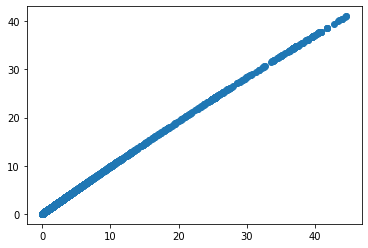

In [20]:
plt.scatter(-np.log(df_['pval_trc_r']), -np.log(df_['pval_trc_py']))

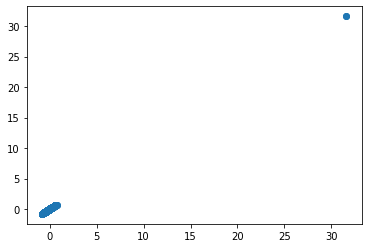

In [21]:
plt.scatter((df_['beta_trc_r']), (df_['beta_trc_py']))

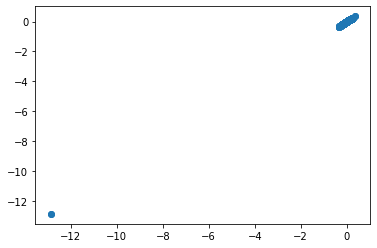

In [22]:
plt.scatter((df_['beta_asc_r']), (df_['beta_asc_py']))

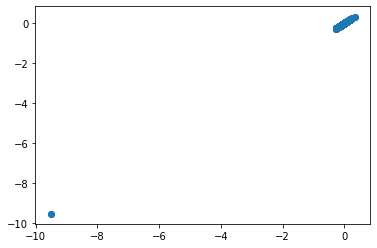

In [23]:
plt.scatter((df_['beta_meta_r']), (df_['beta_meta_py']))